## XGBRegresor | KFOLD-10 & OptunaTunning

Optuna:
Optuna is an open-source hyperparameter optimization toolkit designed to deal with machine learning and non-machine learning(as long as we can define the objective function). It provides a very imperative interface to fully support Python language with the highest modularity level in code


#### **Necessary Library**

In [1]:
#Import necessay libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
import seaborn as sns

#Preprocessing
from sklearn import model_selection
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


#### **KFold**-->Split=5

In [2]:
#import the data and shape
train = pd.read_csv("../input/30-days-of-ml/train.csv")
test = pd.read_csv("../input/30-days-of-ml/test.csv")
print(train.shape,test.shape)
#add extra one columns
train['kfold']=-1
#Distributing the data 5 shares
kfold = model_selection.KFold(n_splits=10, shuffle= True, random_state = 42)
for fold, (train_indicies, valid_indicies) in enumerate(kfold.split(X=train)):
    #print(fold,train_indicies,valid_indicies)
    train.loc[valid_indicies,'kfold'] = fold

    
print(train.kfold.value_counts()) #total data 300000 = kfold split :5 * 60000

#output of train folds data
train.to_csv("trainfold_10.csv",index=False)

(300000, 26) (200000, 25)
0    30000
1    30000
2    30000
3    30000
4    30000
5    30000
6    30000
7    30000
8    30000
9    30000
Name: kfold, dtype: int64


### **Read input data**

In [3]:
#import the data and shape
train = pd.read_csv("./trainfold_10.csv")
test = pd.read_csv("../input/30-days-of-ml/test.csv")
sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")
#preview the train data
print(train.shape,test.shape)
train.sample()

(300000, 27) (200000, 25)


,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target,kfold
176448,294188,A,B,A,C,B,D,C,E,G,...,0.417667,0.501534,0.570452,0.808488,0.878065,0.802157,0.852899,0.170563,8.115577,7


### **HeatMap analysis of Missing data**

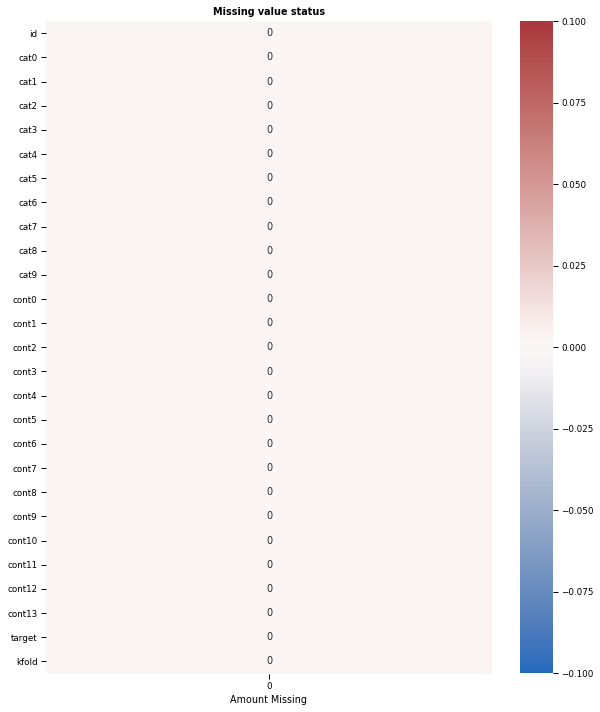

In [4]:
plt.rc('figure',figsize= (10,12))
sns.set_context('paper',font_scale=1)

plt.title('Missing value status',fontweight = 'bold')
ax = sns.heatmap(train.isnull().sum().to_frame(),annot=True,fmt = 'd',cmap = 'vlag')
ax.set_xlabel('Amount Missing')
plt.show()


#### Statistical analysis

In [5]:
#statistical analysis of train data
print("Describe",train.describe())
print("--------------------------------------------------------------------------")

#information of train data
print("Information",train.info())
print("---------------------------------------------------------------------------")

print("correlation",train.corr())

Describe                   id          cont0          cont1          cont2  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean   250018.576947       0.527335       0.460926       0.490498   
std    144450.150010       0.230599       0.214003       0.253346   
min         1.000000      -0.118039      -0.069309      -0.056104   
25%    124772.500000       0.405965       0.310494       0.300604   
50%    250002.500000       0.497053       0.427903       0.502462   
75%    375226.500000       0.668060       0.615113       0.647512   
max    499999.000000       1.058443       0.887253       1.034704   

               cont3          cont4          cont5          cont6  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.496689       0.491654       0.510526       0.467476   
std         0.219199       0.240074       0.228232       0.210331   
min         0.130676       0.255908       0.045915      -0.224689   
25%         0.329783    

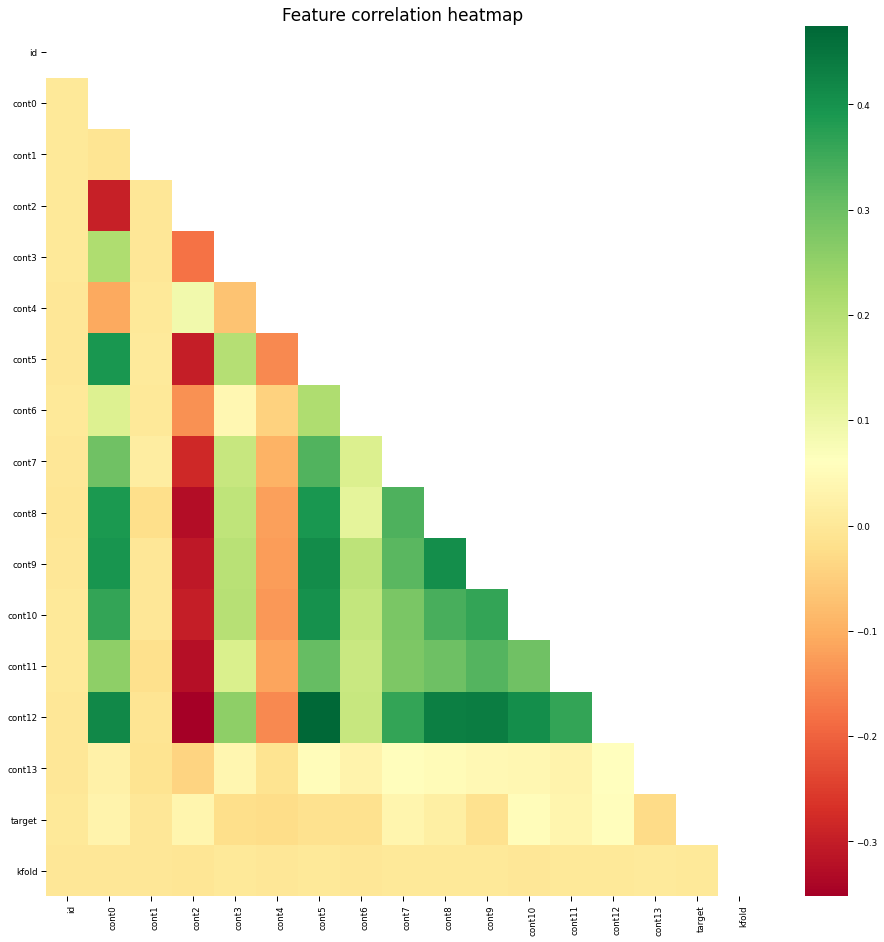

In [6]:
# Plot dataframe
heat = train.corr().round(5)

# Mask to hide upper-right part of plot as it is a duplicate
mask = np.zeros_like(heat)
mask[np.triu_indices_from(mask)] = True

# Making a plot
plt.figure(figsize=(16,16))
ax = sns.heatmap(heat, annot=False, mask=mask, cmap="RdYlGn", annot_kws={"weight": "bold", "fontsize":13})
ax.set_title("Feature correlation heatmap", fontsize=17)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor", weight="normal")
plt.setp(ax.get_yticklabels(), weight="normal",
         rotation_mode="anchor", rotation=0, ha="right")
plt.show();



### **Build XgboostRegressor Model**

In [7]:
#store the final_prediction data and score
final_predictions = []
score= []

#features(categorical and numerical datas separate)
useful_features = [c for c in train.columns if c not in ("id","target","kfold")]
object_cols = [col for col in useful_features if 'cat' in col]
numerical_cols = [col for col in useful_features if 'cont' in col]
test = test[useful_features]

for fold in range(10):
    xtrain = train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    ytrain = xtrain.target
    yvalid = xvalid.target
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    #ordinal encode categorical colums and standardscaler is applied (mean0,sd=1)
    ordinal_encoder = OrdinalEncoder()
    
    xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
    xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])
    xtest[object_cols] = ordinal_encoder.transform(xtest[object_cols])
    
    scaler = preprocessing.StandardScaler()
    xtrain[numerical_cols] = scaler.fit_transform(xtrain[numerical_cols])
    xvalid[numerical_cols] = scaler.transform(xvalid[numerical_cols])
    xtest[numerical_cols] = scaler.transform(xtest[numerical_cols])
    
    #Model hyperparameter of XGboostRegressor
    xgb_params = {
        'learning_rate': 0.08837982506397186,
        'reg_lambda': 1.5986606673969327e-06,
        'reg_alpha': 4.844826299110059e-08,
        'subsample': 0.4493238068204164,
        'colsample_bytree': 0.9987937142187765,
        'max_depth': 2,
        'booster': 'gbtree', 
        'reg_lambda': 0.0008746338866473539,
        'reg_alpha': 23.13181079976304,
        'random_state':43,
        'n_estimators':10000
    }
    
    model= XGBRegressor(**xgb_params,
                       tree_method='gpu_hist',
                       predictor='gpu_predictor',
                       gpu_id=0)
    model.fit(xtrain,ytrain,early_stopping_rounds=300,eval_set=[(xvalid,yvalid)],verbose=2000)
    preds_valid = model.predict(xvalid)
    
    #Training model apply the test data and predict the output
    test_pre = model.predict(xtest)
    final_predictions.append(test_pre)
    
    #Rootmeansquared output
    rms = mean_squared_error(yvalid,preds_valid,squared=False)
    
    score.append(rms)
    #way of output is display
    print(f"fold:{fold},rmse:{rms}")

#mean of repeation of fold data and identify the  mean and standard deviation 
print(np.mean(score),np.std(score))

[0]	validation_0-rmse:7.10842
[2000]	validation_0-rmse:0.71927
[4000]	validation_0-rmse:0.71822
[5031]	validation_0-rmse:0.71801
fold:0,rmse:0.7179314219000038
[0]	validation_0-rmse:7.08981
[2000]	validation_0-rmse:0.71875
[4000]	validation_0-rmse:0.71767
[4249]	validation_0-rmse:0.71765
fold:1,rmse:0.7176279890986057
[0]	validation_0-rmse:7.09563
[2000]	validation_0-rmse:0.71718
[4000]	validation_0-rmse:0.71654
[4165]	validation_0-rmse:0.71654
fold:2,rmse:0.7164618525050513
[0]	validation_0-rmse:7.09597
[2000]	validation_0-rmse:0.72017
[4000]	validation_0-rmse:0.71902
[4271]	validation_0-rmse:0.71901
fold:3,rmse:0.7189910305000013
[0]	validation_0-rmse:7.08997
[2000]	validation_0-rmse:0.72442
[4000]	validation_0-rmse:0.72325
[4251]	validation_0-rmse:0.72326
fold:4,rmse:0.7232367928411212
[0]	validation_0-rmse:7.09715
[2000]	validation_0-rmse:0.71686
[3865]	validation_0-rmse:0.71653
fold:5,rmse:0.7165099816024667
[0]	validation_0-rmse:7.09786
[2000]	validation_0-rmse:0.72019
[4000]	val

#### **Predictions | SubmissionFile**

In [8]:
#prediction of data
preds = np.mean(np.column_stack(final_predictions),axis=1)
print(preds)
sample_submission.target = preds
sample_submission.to_csv("submission.csv",index=False)
print("success")

[8.111847  8.381666  8.405363  ... 8.4782295 8.168773  7.9760046]
success


**Reference:**

1. [https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html](http://)

2. [https://www.kaggle.com/venkatkumar001/30days-optuna-xgb](http://)
3. [https://www.kaggle.com/miguelquiceno/30-days-kfold-xgboost](http://)
4. [https://www.kaggle.com/hamzaghanmi/xgboost-hyperparameter-tuning-using-optuna](http://)

#  **ThankYou**